/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


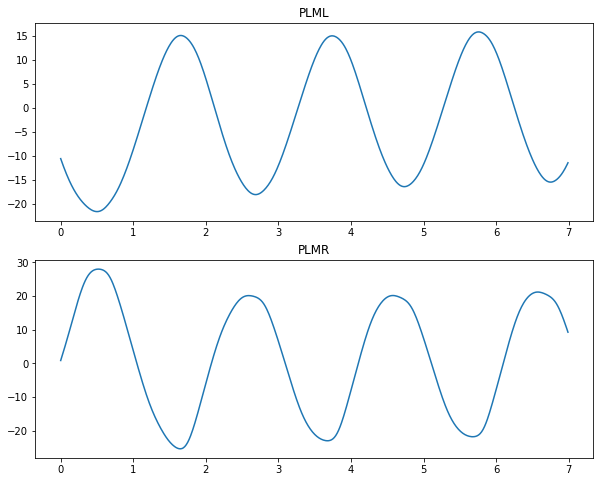

In [12]:
import project_path
from model.neural_model import NeuralModel
from model.neuron_metadata import NeuronMetadataCollection
from model.data_accessor import get_data_file_abs_path
from util.plot_util import *

neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
model = NeuralModel(neuron_metadata_collection)

model.seed = 0
model.set_current_injection("AVBL", 2.3)
model.set_current_injection("AVBR", 2.3)
model.set_current_injection("PLML", 1.4)
model.set_current_injection("PLMR", 1.4)

model.init()
(v_mat, s_mat, v_normalized_mat) = model.run(1000)

# The oscillatory dynamic doesn't stabilize until about dt*300 onwards.
# Also, interactome analysis is done after the first 50 timesteps.
fwd_dynamics = v_normalized_mat[300:,:]

fig = plot_potentials(['PLML', 'PLMR'], fwd_dynamics, neuron_metadata_collection)
fig.show()